In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from datasets import Dataset

/ext3/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('./data/final_data/train.csv')
data = data.rename(columns={'score': 'labels'})

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   labels     17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [4]:
print(sorted(data['labels'].unique()))
data['labels'] = data['labels'] - 1
# print(sorted(data['labels'].unique()))

num_classes = data["labels"].nunique()
print(num_classes)

[1, 2, 3, 4, 5, 6]
6


In [5]:
# print(sorted(data['score'].unique()))
# data['score'] = data['score'] - 1
# # print(sorted(data['score'].unique()))

# num_classes = data["score"].nunique()
# print(num_classes)

In [6]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')
# tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def preprocess_function(examples):
    # Assuming 'text' and 'label' are column names in your dataset
    result = tokenizer(examples['full_text'], padding="max_length", truncation=True, max_length=512)
    result['labels'] = examples['labels']
    return result

# Apply the function across the dataset
print(data.columns)
dataset = Dataset.from_pandas(data.iloc[:,1:])
tokenized_dataset = dataset.map(preprocess_function, batched=True)

/ext3/miniconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/ext3/miniconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Index(['essay_id', 'full_text', 'labels'], dtype='object')


Map: 100%|██████████| 17307/17307 [00:06<00:00, 2844.75 examples/s]


In [7]:
print(tokenized_dataset.features)


{'full_text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [8]:
split_datasets = tokenized_dataset.train_test_split(test_size=0.2, shuffle=True, seed=46)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

In [9]:
print(train_dataset.features)
print(eval_dataset.features)


{'full_text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
{'full_text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [10]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels.flatten(), predictions.flatten())
    kappa = cohen_kappa_score(labels.flatten(), predictions.flatten(), weights="quadratic")
    return {
        'accuracy': accuracy,
        'kappa': kappa
    }


In [11]:
import math
from transformers import TrainerCallback

class CosineAnnealingScheduler(TrainerCallback):
    """ Custom LR Scheduler that implements a cosine annealing schedule with warmup. """

    def __init__(self, optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1):
        self.num_warmup_steps = num_warmup_steps
        self.num_training_steps = num_training_steps
        self.num_cycles = num_cycles
        self.last_epoch = last_epoch
        self.optimizer = optimizer

    def on_step_begin(self, args, state, control, **kwargs):
        """ Called right before a training step in the main training loop. """
        step = state.global_step
        if step < self.num_warmup_steps:
            lr_scale = float(step) / float(max(1, self.num_warmup_steps))
        else:
            progress = float(step - self.num_warmup_steps) / float(max(1, self.num_training_steps - self.num_warmup_steps))
            lr_scale = max(0.0, 0.5 * (1.0 + math.cos(math.pi * self.num_cycles * 2.0 * progress)))
        
        for group in self.optimizer.param_groups:
            group['lr'] = lr_scale * group['initial_lr']


In [12]:
from transformers import TrainerCallback

class MetricsCallback(TrainerCallback):
    "A callback that stores all intermediate training, validation losses and validation accuracy."

    def __init__(self):
        super().__init__()
        self.training_losses = []
        self.validation_losses = []
        self.validation_accuracy = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Logs appear as a dictionary. Check if loss and eval_loss are in the dictionary and append them.
        if 'loss' in logs:
            self.training_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.validation_losses.append(logs['eval_loss'])
        if 'eval_accuracy' in logs:
            self.validation_accuracy.append(logs['eval_accuracy'])


In [13]:
from transformers import AdamW, TrainingArguments, Trainer, AutoModelForSequenceClassification

num_epochs = 7

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",     # evaluation is done at the end of each epoch
    save_strategy="epoch",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="kappa"
)

model = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-base', num_labels=num_classes)

optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = num_epochs * len(train_dataset) // training_args.per_device_train_batch_size
scheduler_callback = CosineAnnealingScheduler(optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)
metrics_callback = MetricsCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    optimizers=(optimizer, None),
    compute_metrics=compute_metrics,
    callbacks=[scheduler_callback, metrics_callback]
)

2024-05-13 21:19:41.452606: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 21:19:43.126183: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 21:19:47.667275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/ext3/miniconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use 

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Kappa
1,1.088400,0.847143,0.634315,0.761299
2,0.843800,0.787862,0.660312,0.809548
3,0.758900,0.886616,0.636049,0.798076
4,0.667400,0.817964,0.655979,0.810284
5,0.590700,0.859054,0.658290,0.817964
6,0.522500,0.911079,0.645869,0.805913
7,0.489000,0.918723,0.649624,0.807585


TrainOutput(global_step=6062, training_loss=0.7086658383391156, metrics={'train_runtime': 4700.8497, 'train_samples_per_second': 20.616, 'train_steps_per_second': 1.29, 'total_flos': 2.550078102813696e+16, 'train_loss': 0.7086658383391156, 'epoch': 7.0})

In [15]:
training_losses = metrics_callback.training_losses
validation_losses = metrics_callback.validation_losses
validation_accuracy = metrics_callback.validation_accuracy

print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)
print("Validation Accuracy:", validation_accuracy)

Training Losses: [1.0884, 0.8438, 0.7589, 0.6674, 0.5907, 0.5225, 0.489]
Validation Losses: [0.8471428155899048, 0.7878618240356445, 0.8866164684295654, 0.8179641962051392, 0.8590542674064636, 0.9110787510871887, 0.9187228083610535]
Validation Accuracy: [0.634315424610052, 0.6603119584055459, 0.6360485268630849, 0.6559792027729636, 0.6582900057770075, 0.6458694396302715, 0.6496244945118429]


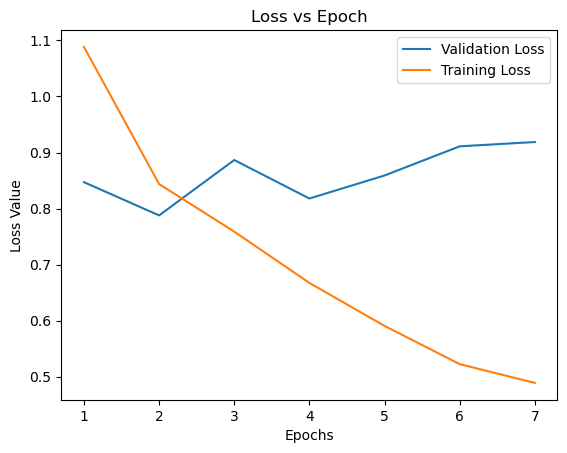

In [20]:
plt.plot(list(range(1,num_epochs+1)),validation_losses, label="Validation Loss")
plt.plot(list(range(1,num_epochs+1)),training_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

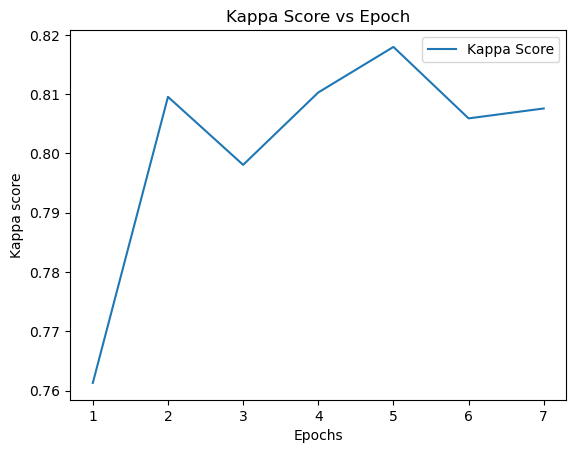

In [18]:
kappa_values = [0.761299, 0.809548, 0.798076, 0.810284, 0.817964, 0.805913, 0.807585]


plt.plot(list(range(1,num_epochs+1)),kappa_values, label="Kappa Score")
plt.xlabel("Epochs")
plt.ylabel("Kappa score")
plt.title("Kappa Score vs Epoch")
plt.legend()
plt.show()

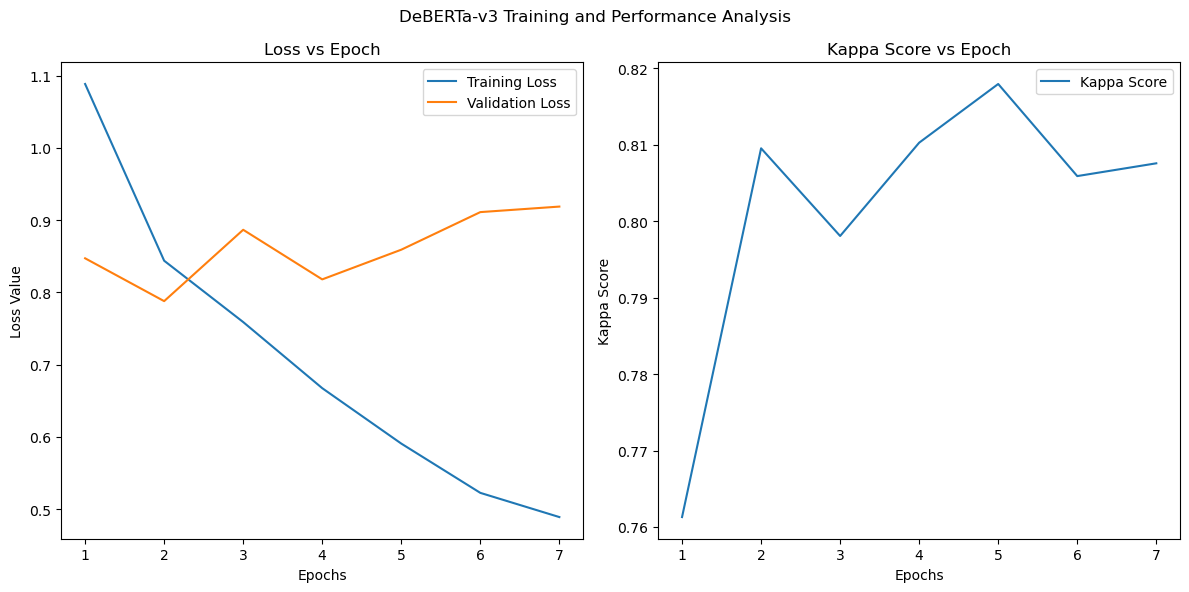

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(list(range(1,num_epochs+1)),training_losses, label="Training Loss")
ax1.plot(list(range(1,num_epochs+1)),validation_losses, label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss Value")
ax1.set_title("Loss vs Epoch")
ax1.legend()

ax2.plot(list(range(1,num_epochs+1)),kappa_values, label="Kappa Score")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Kappa Score")
ax2.set_title("Kappa Score vs Epoch")
ax2.legend()

plt.suptitle("DeBERTa-v3 Training and Performance Analysis")
plt.tight_layout()

plt.show()